This notebook shows the process of masking automatically using normalization of pixel values.

In [9]:
from PIL import Image
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage.io


#### Load balanced train dataset

In [2]:
import pandas as pd 

train_balanced_df = pd.read_csv('../src/data/split_data/train_balanced.csv')
print(f'The shape of the dataframe: {train_balanced_df.shape}')
train_balanced_df.head()

The shape of the dataframe: (14984, 2)


,Label,Image_Path
0,basophil,../src/data/split_data/train_balanced/basophil...
1,basophil,../src/data/split_data/train_balanced/basophil...
2,basophil,../src/data/split_data/train_balanced/basophil...
3,basophil,../src/data/split_data/train_balanced/basophil...
4,basophil,../src/data/split_data/train_balanced/basophil...


In [3]:
# Function to apply normalization
def apply_normalization(image):
    """
    Apply normalization to a grayscale image.

    Parameters:
    - image (numpy.ndarray): Input grayscale image.

    Returns:
    - normalized_image (numpy.ndarray): Normalized image with pixel values
      scaled between 0 and 1.
    """
    normalized_image = cv2.normalize(image, None,
                                     alpha=0, beta=1,
                                     norm_type=cv2.NORM_MINMAX,
                                     dtype=cv2.CV_8UC1)  # dtype=cv2.CV_32F
    return normalized_image


In [4]:
# Function to apply a color mask
def apply_color_mask(original_image, stretched_image):
    """
    Apply a color mask to retain original colors in the stretched regions.

    Parameters:
    - original_image (numpy.ndarray): Input RGB image.
    - stretched_image (numpy.ndarray): Contrast-stretched grayscale image.

    Returns:
    - color_mask (numpy.ndarray): Color-masked image with original colors in
      stretched regions.
    """
    mask = stretched_image == 0
    color_mask = np.zeros_like(original_image)
    color_mask[mask] = original_image[mask]
    return color_mask


def process_and_save_masked_images(df, save_dir):
    """
    Process all images in the DataFrame, save the masked images,
    and return a new DataFrame with paths to the masked images.

    Parameters:
    - df (pandas.DataFrame): DataFrame containing image paths and labels.
    - save_dir (str): Directory to save the masked images.

    Returns:
    - new_df (pandas.DataFrame): DataFrame with original labels and
      paths to the masked images.
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    processed_images = []

    for _, row in df.iterrows():
        image_path = row['Image_Path']
        label = row['Label']
        image_rgb = skimage.io.imread(image_path)
        image = skimage.io.imread(image_path, as_gray=True)

        # Scale image to [0, 255]
        image = (image * 255).astype(np.uint8)

        # Apply contrast stretching
        stretched_image = apply_normalization(image)

        # Apply color mask
        color_stretched_image = apply_color_mask(image_rgb, stretched_image)

        # Save the masked image
        label_dir = os.path.join(save_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        masked_image_path = os.path.join(label_dir,
                                         os.path.basename(image_path))
        skimage.io.imsave(masked_image_path, color_stretched_image)

        # Store the path to the masked image along with its label
        processed_images.append({'Label': label,
                                 'Image_Path': masked_image_path})

    # Create a new DataFrame with the processed images
    new_df = pd.DataFrame(processed_images)
    return new_df


In [14]:
# Function to display original and normalized images
def display_normalized_images(df, num_samples=4):
    """
    Display original and normalized images for random samples from each class.

    Parameters:
    - df (pandas.DataFrame): DataFrame containing image paths and labels.
    - num_samples (int): Number of random samples to display per class.

    Returns:
    - None
    """
    class_labels = df['Label'].unique()
    images = []
    titles = []

    for label in class_labels:
        class_df = df[df['Label'] == label]
        sample_df = class_df.sample(n=num_samples, random_state=42)

        for _, row in sample_df.iterrows():
            image_path = row['Image_Path']
            image_rgb = skimage.io.imread(image_path)
            image = skimage.io.imread(image_path, as_gray=True)

            #if check_image_properties(image)['scale'] == '0-1':
            #    image = (image * 255).astype(np.uint8)

            # Apply normalization
            normalized_image = apply_normalization(image)

            # Apply color mask
            color_normalized_image = apply_color_mask(image_rgb,
                                                      normalized_image)

            images.append((image_rgb, color_normalized_image))
            titles.append((f'Original ({label})', 'Normalized'))

    num_classes = len(images) // num_samples
    fig, axs = plt.subplots(num_classes, num_samples * 2,
                            figsize=(15, 2 * num_classes))

    for i in range(num_classes):
        for j in range(num_samples):
            idx = i * num_samples + j
            image, color_normalized_image = images[idx]
            title1, title2 = titles[idx]

            axs[i, j * 2].imshow(image)
            axs[i, j * 2].set_title(title1)
            axs[i, j * 2].axis('off')

            axs[i, j * 2 + 1].imshow(color_normalized_image)
            axs[i, j * 2 + 1].set_title(title2)
            axs[i, j * 2 + 1].axis('off')

    plt.tight_layout()
    plt.show()

In [10]:
# # Define the path to save masked images
masked_images_dir = '../src/data/split_data/train_balanced_masked'

# # Process and save masked images
train_balanced_masked_df = process_and_save_masked_images(train_balanced_df, masked_images_dir)


In [11]:
# # Save the DataFrame with masked image paths
train_balanced_masked_df.to_csv('../src/data/split_data/train_balanced_masked.csv', index=False)


In [12]:
train_masked_df = pd.read_csv('../src/data/split_data/train_balanced_masked.csv')
print(f'The shape of the dataframe: {train_masked_df.shape}')
train_masked_df.head()

The shape of the dataframe: (14984, 2)


,Label,Image_Path
0,basophil,../src/data/split_data/train_balanced_masked/b...
1,basophil,../src/data/split_data/train_balanced_masked/b...
2,basophil,../src/data/split_data/train_balanced_masked/b...
3,basophil,../src/data/split_data/train_balanced_masked/b...
4,basophil,../src/data/split_data/train_balanced_masked/b...


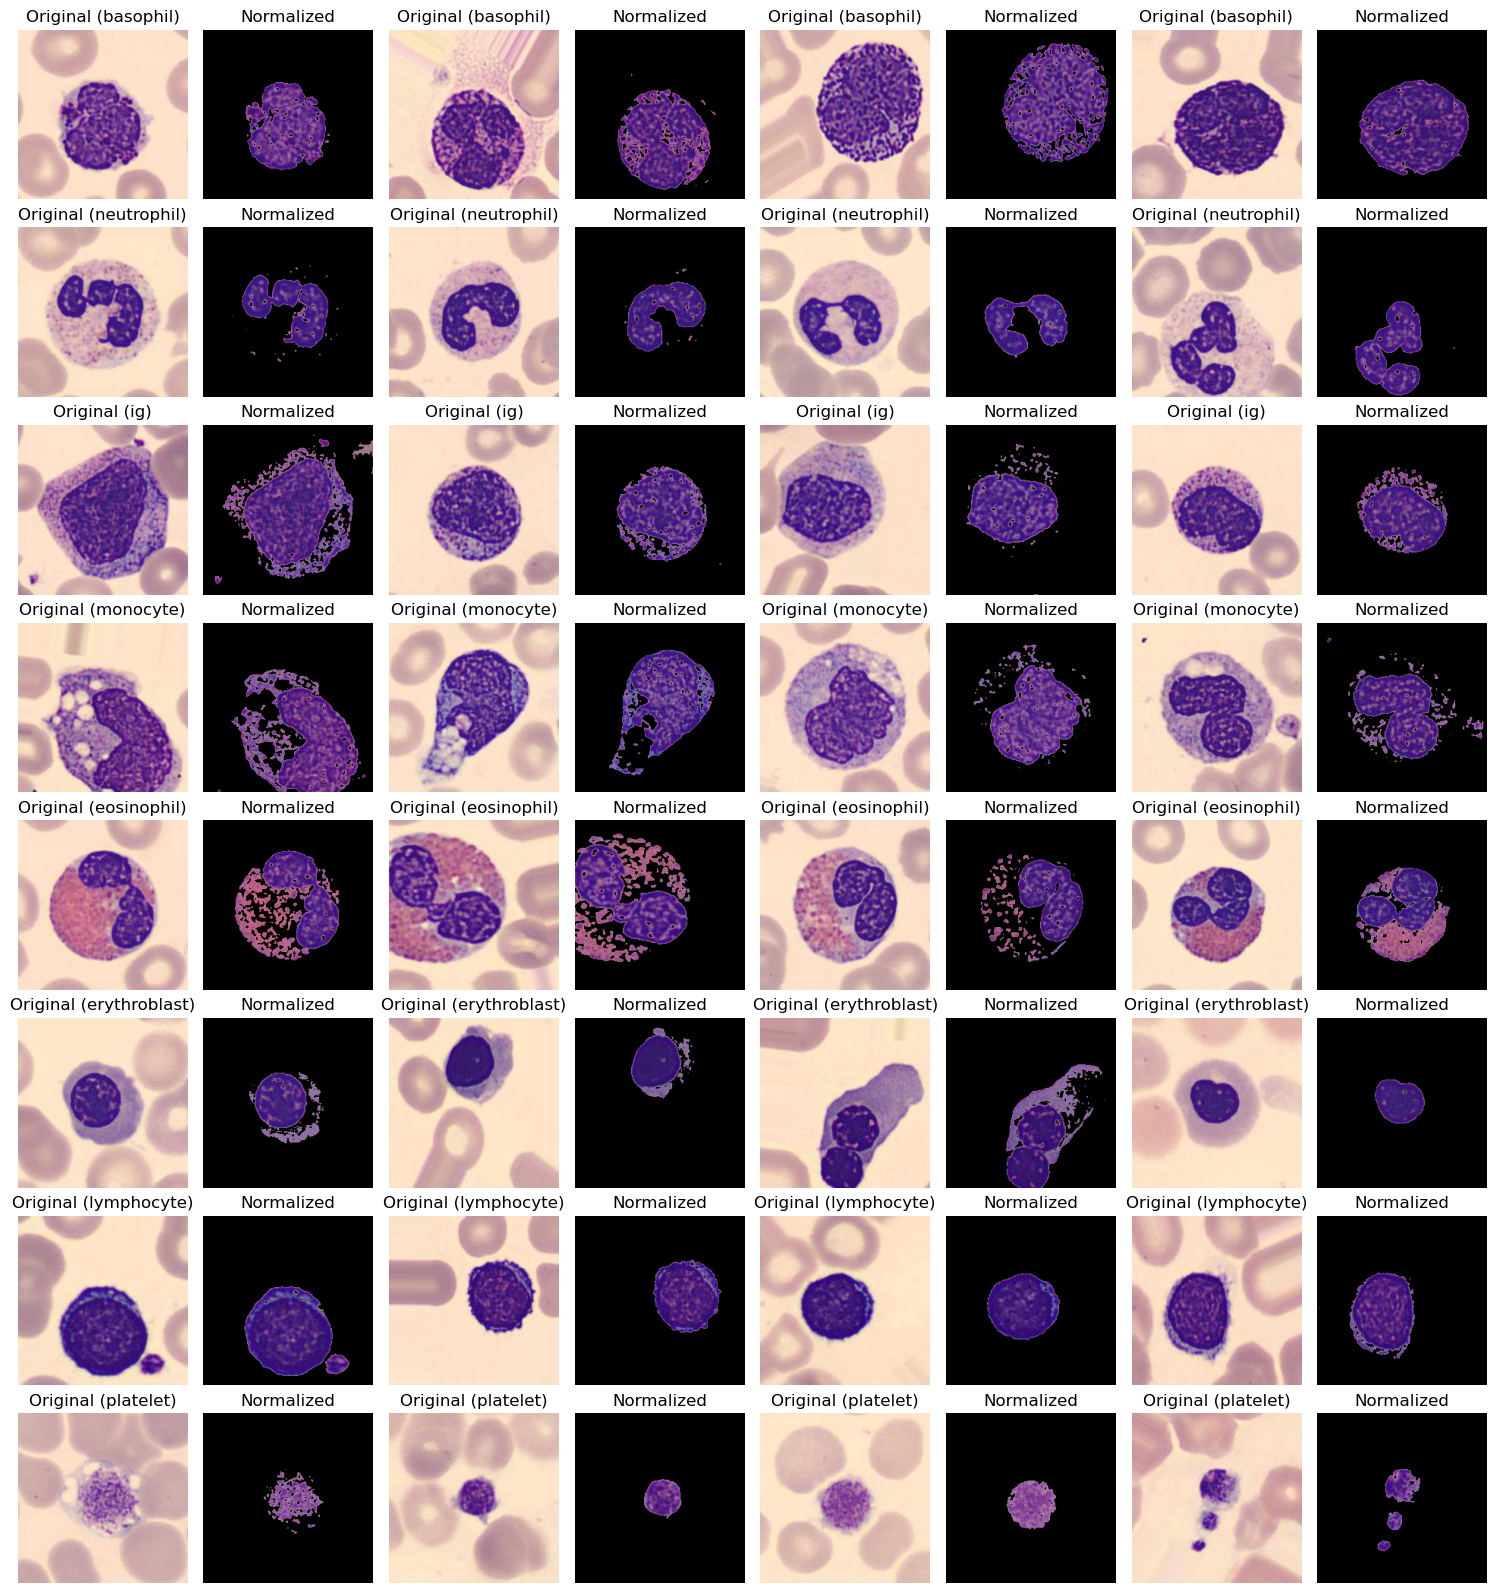

In [15]:
# Display some masked images for verification
display_normalized_images(train_balanced_df)